**Single-Cell Analysis of Malaria Infection in Mice**

Single-cell RNA sequencing (scRNA-Seq) data from wild-type and malaria-infected mouse cells will be analyzed using the following code to study gene expression differences and cell changes during malarial infection. Using ScanPy package in Python, the data will be pre-processed, integrated across the conditions using two different methods, and clustered according to cell types which will then be annotated. Differentially expressed genes will be identified using DE analysis. Pseudobulk aproach to the two integrated datasets will also be used to determine which method works best. A trajectory analysis will also be performed using PAGA to track how cells progress, with results visualized through UMAP and PHATE. 

**Importing Necessary Libraries**

scanpy will be used for single-cell data manipulation and visualization, while bbknn and harmonypy are included for data integration. pandas and numpy will be used used for data manipulation as well. matplotlib and seaborn will be used for plotting, and gseapy will help with gene set enrichment analysis. random will be used for creating pseudo-replicates in pseudo-bulk approach. pydeseq2 is included for differential expression analysis, and venn to create venn diagrams comapring different methods. phate is imported for dimensionality reduction and trajectory analysis. These libraries will help perform data processing, clustering, differential expression analysis, and visualization.

In [59]:
#Import necessary libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import scanpy.external as sce
import bbknn
import harmonypy as hm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from venn import venn
import phate

In [60]:
#Set verbosity for detailed outputs to track progress or errors 
sc.settings.verbosity = 2

**Cluster and UMAP Visualization**

The cluster_umap and cluster_umap_paga functions perform Leiden clustering and generate a UMAP visualization of the data. They takes the following parameters:

adata: The AnnData object containing the single-cell data.

title: A custom title for the UMAP plot.

resolution: For Leiden clustering that controls the granularity of the clusters.

n_iterations: The number of iterations for the Leiden algorithm, set to default as 2.

random_state: For reproducibility of the clustering process, set to default as 0.


The functions first apply Leiden clustering to the data, then cluster_umap performs standard UMAP while cluster_umap_paga creates a PAGA graph first and then uses it to create UMAP. First function returns one UMAP plot colored by the Leiden cluster identities, while the second one gives both UMAP as well as PAGA plots. These plots help visualize how the data is distributed across clusters.

In [61]:
#Function to cluster the data and generate UMAP visualization
def cluster_umap(adata, title, resolution, n_iterations=2, random_state=0):
   
    #Leiden clustering
    sc.tl.leiden(adata, n_iterations=n_iterations, resolution=resolution, random_state=random_state, flavor='igraph', directed=False)
    
    #Perform UMAP
    sc.tl.umap(adata)
    
    #Plot UMAP with color by 'leiden' cluster
    sc.pl.umap(adata, color='leiden', title=title)

In [62]:
#Function to cluster the data with PAGA and generate UMAP visualization
def cluster_umap_paga(adata, umap_title, paga_title, resolution, n_iterations=2, random_state=0):
    
    #Perform PAGA 
    sc.tl.paga(adata)
    
    #Plot PAGA graph
    sc.pl.paga(adata, title=paga_title, color='leiden')
    
    #UMAP initialization from PAGA
    sc.tl.umap(adata, init_pos='paga')
    
    #Plot UMAP with the title
    sc.pl.umap(adata, color='leiden', title=umap_title)


**Differential Expression Analysis for single-cell Clusters**

The de_analysis function performs differential expression analysis using a t-test to compare gene expression between conditions. It takes the following parameters:

cluster_data: The AnnData object containing the cluster data.

condition_column: The column specifying the condition for each sample.

reference_condition: The condition to compare other conditions against, default is set as'Wild Type'.

pval_threshold: The threshold for adjusted p-values to filter significant genes, set to default as 0.01 as required to obtain only significant values.

logfc_threshold: The threshold for log2 fold change to filter genes, set to default as 0.5 as required to obtain upregulated genes.

The function uses Scanpy's rank_genes_groups method to perform the t-test and extracts the results. The genes are then filtered based on the adjusted p-value and log2 fold change thresholds. The filtered genes are returned as a DataFrame.

In [63]:
#Function to perform differential expression analysis for clusters
def de_analysis(cluster_data, condition_column='condition', reference_condition='Wild Type', pval_threshold=0.01, logfc_threshold=0.5):
    
    #Differential expression using t-test with rank genes function
    sc.tl.rank_genes_groups(cluster_data, groupby=condition_column, method='t-test', reference=reference_condition)
    
    #Extract results
    de_results = cluster_data.uns['rank_genes_groups']
    results_df = pd.DataFrame(de_results['names'])
    pvals_adj = pd.DataFrame(de_results['pvals_adj'])
    logfoldchanges = pd.DataFrame(de_results['logfoldchanges'])
    
    #Filter genes by adjusted p-value and log fold change
    filtered_genes = results_df[
        (pvals_adj.iloc[:, 0] < pval_threshold) &  
        (logfoldchanges.iloc[:, 0] > logfc_threshold)  
    ]
    
    return filtered_genes

**Generating Pseudobulk Data from Integrated Single-Cell Data**

The pseudobulk function generates pseudobulk replicates from integrated single-cell data for a specified cluster. It takes the following parameters:

adata: The AnnData object containing the single-cell data.

cluster_name: The name of the cluster for which pseudobulk replicates will be created.

num_replicates: The number of pseudobulk replicates to generate, set default is 2.

scaling_factor: A factor to scale the counts before rounding to avoid zeroes, set default is 1000.

The function subsets the data based on the specified cluster, and for each sample in that cluster, it shuffles and splits the cells into the specified number of replicates. For each replicate, the mean counts of the cells are calculated, scaled by the scaling factor, and rounded to integers. The function then creates an AnnData object for each replicate and appends it to a list. Finally, all the replicates are concatenated into a single AnnData object, which is returned.

This pseudobulk approach combines individual single-cell data into bulk-like representations, making it suitable for downstream bulk RNA-seq analysis methods.

In [64]:
#Function to generate pseudobulk data from single-cell data
def pseudobulk(adata, cluster_name, num_replicates=2, scaling_factor=1000):
    
    pbs = []  #List to store pseudobulk replicates
    
    #Subset the data for the specific cluster
    cluster_subset = adata[adata.obs['leiden'] == cluster_name]
    print(f'Cluster subset shape: {cluster_subset.shape}')
    
    for sample in cluster_subset.obs['sample'].unique():
        #Filter cells for the current sample
        samp_cell_subset = cluster_subset[cluster_subset.obs['sample'] == sample]
        
        #Convert sparse matrix to dense to avoid long run-times
        samp_cell_subset.X = samp_cell_subset.layers['counts'].toarray() if hasattr(samp_cell_subset.layers['counts'], 'toarray') else samp_cell_subset.layers['counts']
        
        #Shuffle cell indices and split into replicates
        indices = list(samp_cell_subset.obs_names)
        random.shuffle(indices)
        indices_split = np.array_split(np.array(indices), num_replicates)
        
        #Create pseudobulk replicates
        for i, pseudo_rep in enumerate(indices_split):
            mean_counts = samp_cell_subset[pseudo_rep].X.mean(axis=0)  #Mean counts for replicate
            scaled_counts = np.round(mean_counts * scaling_factor).astype(int)  #Scale and round counts
            
            #Create AnnData object for replicate
            mean_counts_2d = np.reshape(scaled_counts, (1, -1))  #Make it a 2D array
            var = samp_cell_subset.var.copy() 
            
            #Create the replicate AnnData object
            rep_adata = sc.AnnData(X=mean_counts_2d, var=var)
            rep_adata.obs_names = [f'{sample}_{i}']
            rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
            rep_adata.obs['replicate'] = i
            pbs.append(rep_adata)
    
    #Concatenate all replicates into one AnnData object
    pb = sc.concat(pbs)
    return pb

**Performing Bulk Differential Expression Analysis**

The bulk_de_analysis function performs bulk differential expression analysis using pydeseq2 on pseudo-bulk data. It takes the following parameters:

adata: The AnnData object containing the single-cell RNA-seq data.

condition_column: The column specifying the condition for each sample.

contrast: A tuple specifying the conditions for DE analysis (default compares 'Infected' vs. 'Wild Type').

min_cells: The minimum number of cells a gene must be expressed in, set default is 1.

pval_threshold: The adjusted p-value threshold for filtering significant genes, set to default as 0.01 as required as required to obtain only significant values.

logfc_threshold: The threshold for log2 fold change to filter genes, set to default as 0.5 as required to obtain upregulated genes

The function gets the count data, creates a DeseqDataSet object, and filters genes expressed in at least a specified number of cells. DESeq2 is then run to perform the differential expression analysis, and results are filtered by adjusted p-value and log2 fold change thresholds. The filtered results are returned as a DataFrame.

In [65]:
#Perform bulk differential expression analysis
def bulk_de_analysis(adata, condition_column='condition', contrast=('condition', 'Infected', 'Wild Type'), 
                      min_cells=1, pval_threshold=0.01, logfc_threshold=0.5):
    
    #Prepare counts data
    counts = pd.DataFrame(adata.X, columns=adata.var_names)
    
    #Create DeseqDataSet object
    dds = DeseqDataSet(counts=counts, metadata=adata.obs, design='~condition')
    
    #Filter genes expressed in at least 'min_cells' cells
    sc.pp.filter_genes(dds, min_cells=min_cells)
    
    #Run DESeq2 analysis
    dds.deseq2()
    
    #Perform DE stats using given contrast
    stat_res = DeseqStats(dds, contrast=contrast)
    stat_res.summary()
    
    #Get DE results and sort by statistical significance
    try:
        de_results = stat_res.results_df
    except AttributeError:
        de_results = stat_res.get_results()
    
    de_results_sorted = de_results.sort_values('stat', ascending=False)
    
    #Filter results based on p-value and logFC thresholds
    filtered_de_results = de_results_sorted[
        (de_results_sorted['padj'] < pval_threshold) & 
        (de_results_sorted['log2FoldChange'] > logfc_threshold)
    ]
    
    return filtered_de_results

**Loading and Concatenating Single-Cell Data**

The following code loads count data and metadata from CSV files for each sample, and concatenates the data into a single AnnData object:

counts: A dictionary with file paths for the counts matrices of each sample.

metadatas: A dictionary with file paths for the metadata associated with each sample.

The script iterates over the counts data for each sample and transposes the count matrix. It then loads the corresponding metadata, merges it with the count data, and stores the resulting AnnData object in a dictionary adatas. After processing all samples, the data is concatenated into one AnnData object adata using sc.concat, with the sample labels as metadata. Finally, the obs_names_make_unique() method is called to ensure unique observation names across all samples.

This process ensures that all samples are combined into a single object for downstream analysis.

In [66]:
#Define file paths for counts and metadata
counts = {
    'WT1': 'WT1/counts_matrix.csv',
    'Inf1': 'Infected1/counts_matrix.csv',
    'Inf2': 'Infected2/counts_matrix.csv'
}
metadatas = {
    'WT1': 'WT1/metadata.csv',
    'Inf1': 'Infected1/metadata.csv',
    'Inf2': 'Infected2/metadata.csv'
}
adatas = {}

#Load count data and metadata into AnnData objects
for sample, filename in counts.items():
    sample_adata = sc.read_csv(filename)
    sample_adata = sample_adata.T  #Transpose matrix to make it similar to metadata files
    sample_adata.var_names_make_unique()
    
    #Load and merge metadata
    metadata = pd.read_csv(metadatas[sample], index_col=0)
    sample_adata.obs = metadata.loc[sample_adata.obs_names]  #Merge metadata
    adatas[sample] = sample_adata

#Concatenate all samples into a single AnnData object
adata = ad.concat(adatas, label='sample')
adata.obs_names_make_unique()

In [101]:
#Print sample counts to obtain total count
print(adata.obs['sample'].value_counts())

sample
WT1     4067
Inf1    2241
Inf2     291
Name: count, dtype: int64


**Mitochondrial Gene Processing and Quality Control**

Mitochondrial genes are selected by identifying genes starting with 'mt-' and QC metrics such as including n_genes_by_counts (the number of genes per cell), total_counts (the total number of reads per cell), and pct_counts_mt (the percentage of mitochondrial genes) are calcuated. These metrics are visualized using violin and scatter plots to assess data quality. Based on the QC plots, cells with extreme high or low gene counts or high mitochondrial expression are filtered out, ensuring only high-quality cells are retained for downstream analysis. A copy of this filtered raw data is also saved for future use.

In [67]:
#Process mitochondrial genes and calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True, log1p=True)

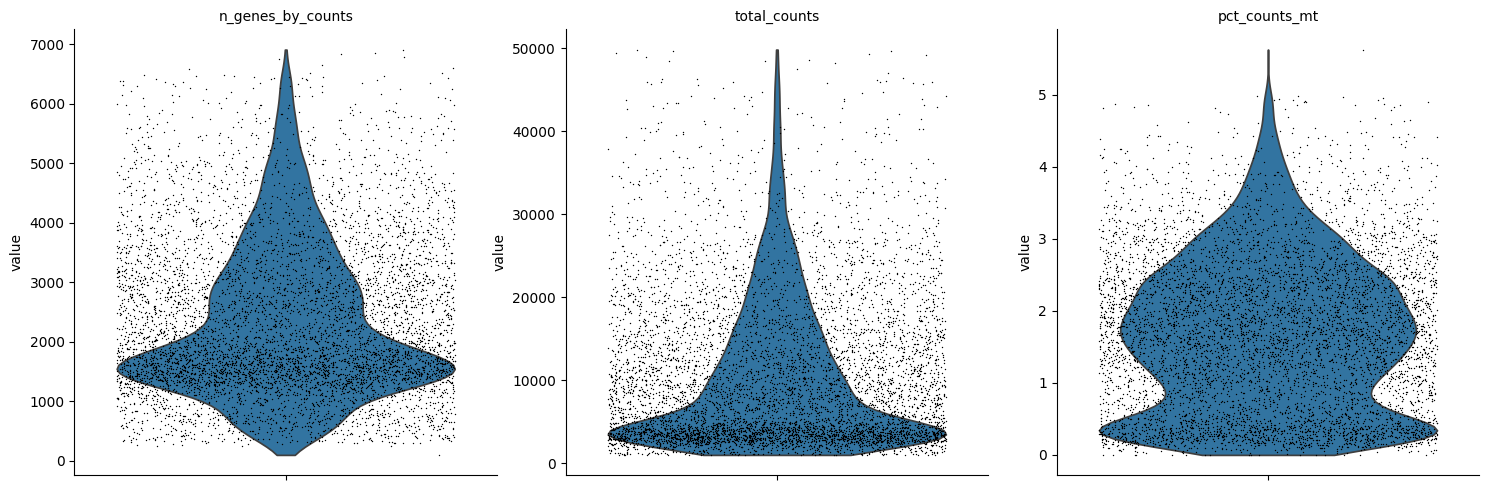

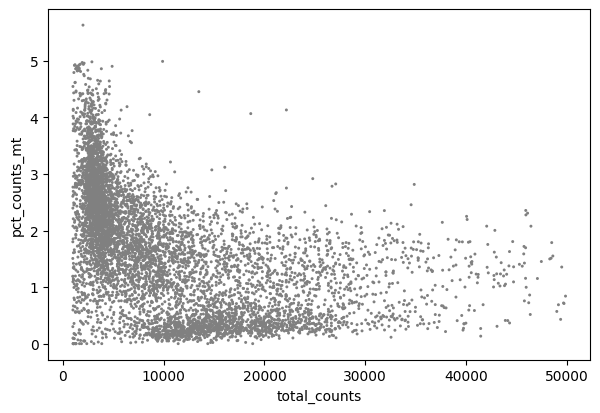

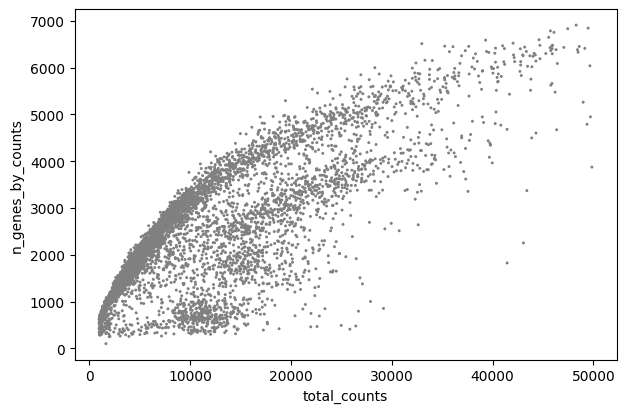

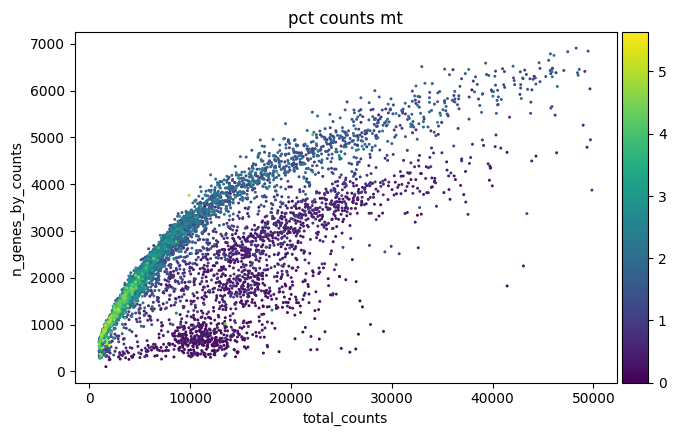

In [68]:
#Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, 'total_counts', 'pct_counts_mt')
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts')
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')

In [69]:
#Filter the cells as per thresholds obtained from QC plots
sc.pp.filter_cells(adata, min_genes=500) #Genes with counts less than 500 are removed as per the QC plots to remove outliers/extreme values
sc.pp.filter_cells(adata, max_genes=40000) #Genes with counts more than 40000 are removed as per the QC plots to remove outliers/extreme values
sc.pp.filter_genes(adata, min_cells=3)   
adata = adata[adata.obs.pct_counts_mt < 4, :] #Mitochondrial threshold set at 4

filtered out 166 cells that have less than 500 genes expressed
filtered out 1080 genes that are detected in less than 3 cells


In [70]:
#Save the raw count data
adata.layers['counts'] = adata.X.copy()

**Data Normalization, Log-Transformation, and Preprocessing for Integration**

The data is normalized, followed by a log-transformation to make the data more suitable for downstream analysis. The normalized and log-transformed data is saved under adata.raw for future use. Highly variable genes are selected using default parameters, with the dataset being subsetted to include only these genes. Total counts and mitochondrial gene percentage are regressed out to improve data quality. The expression values are then scaled to standardize the data for comparable distributions across genes. Copies of the data are created for two methods of integration - BBKNN and Harmony. 

In [71]:
#Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [72]:
#Save normalized and log-transformed count data
adata.raw = adata.copy()

In [73]:
#Select highly variable genes and subsetting to only include those
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key='sample')
adata = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:02)


In [74]:
#Regress out total counts and mitochondrial percentage
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']


/home1/bioinfo-41/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:709: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:01)


In [75]:
#Scale the data to standardize gene expression values 
sc.pp.scale(adata, max_value=10)

In [77]:
#Create copies of the data for two methods of integration)
adata.bbknn = adata.copy()
adata.hm = adata.copy()

**PCA and UMAP Analysis Before Integration**

Principal Component Analysis is applied to reduce the dimensionality of the data and capture the primary sources of variation. The variance ratio is plotted to show the proportion of variability explained by each principal component. The first 50 PCs are considered, and the plot is displayed to identify where the variance starts to level off.

The PCA results are visualized by coloring cells according to sample. These plots provide insights into how different groups are distributed across the PCA dimensions.

Nearest neighbors are then calculated based on the principal components selected from the variance plot. The data is then visualized using UMAP to observe clustering patterns before integration.

In [78]:
#Perform PCA on the data to reduce dimensionality
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:15)


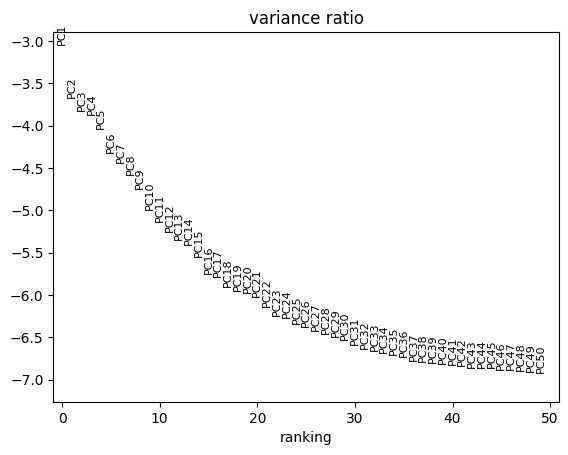

In [79]:
#Plot PCA variance ratio to visualize
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

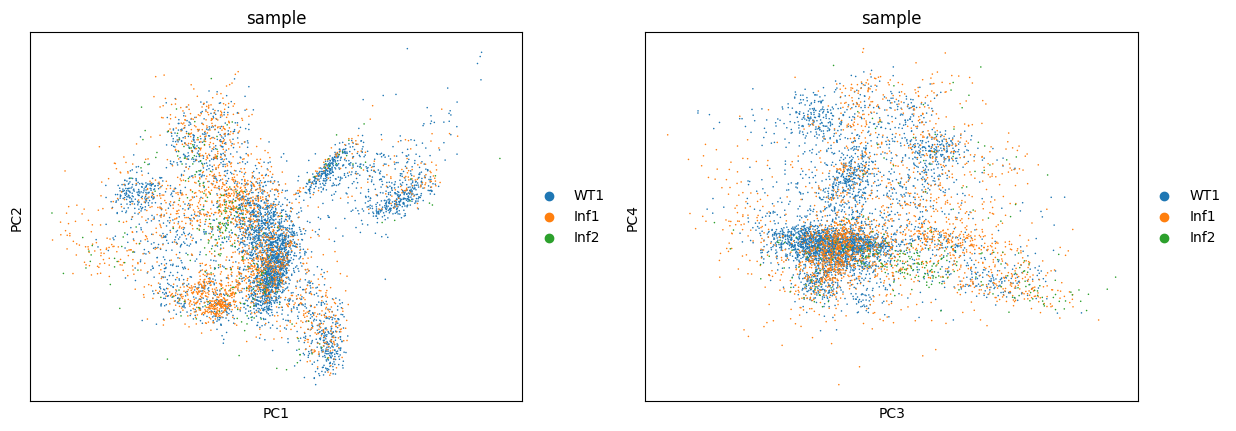

In [80]:
#PCA plots of samples
sc.pl.pca(adata, 
          color=['sample', 'sample'],  
          dimensions=[[0, 1], [2, 3]], 
          ncols=2, 
          size=5)

In [81]:
#Perform nearest neighbors calculation using 40 principal components chosen from plot
sc.pp.neighbors(adata, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:34)


running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:10)


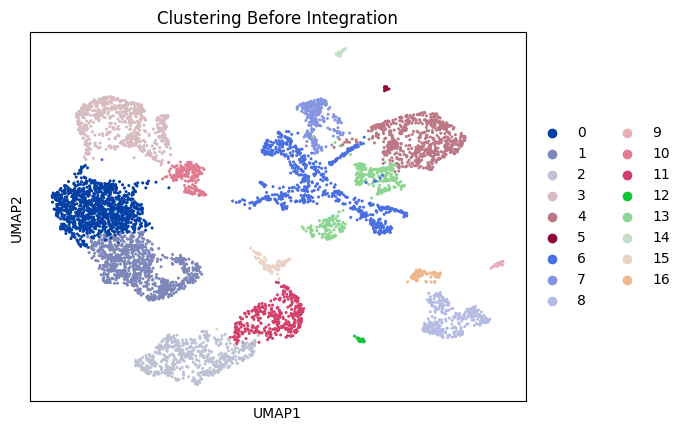

In [85]:
#Visualize clusters using UMAP function before integration using a resolution of 0.3 to give clusters between 10-20 (16 in this case) to get a good understanding of the cell types present in data
cluster_umap(adata, title='Clustering Before Integration', resolution=0.3)

**BBKNN Integration and Clustering Analysis**

Batch-KNN integration is performed to remove batch effects that might be present due to differences in sample origin or other batch-related factors. 

After performing PCA on the previously stored BBKNN data, the sample is used as the batch key for BBKNN integration, and nearest neighbors are recalculated. UMAP visualization is applied to the integrated data to observe clustering patterns post-integration. The rank_genes_groups function is then used to identify marker genes for each cluster which are then plotted.

The number of cells in each cluster is counted to find the three largest clusters. A few of marker genes from those clusters are visualized in UMAP to examine their expression patterns. Finally, these clusters are renamed based on predicted cell types, and an annotated UMAP plot is generated to represent the clusters with their respective identities.

The relative frequency of each cluster is calculated by determining the number of cells in each cluster compared to the total number of cells. A bar plot is generated to visualize the cell type proportions for each sample.

In [86]:
#Perform PCA on the BBKNN copy of data
sc.tl.pca(adata.bbknn, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:16)


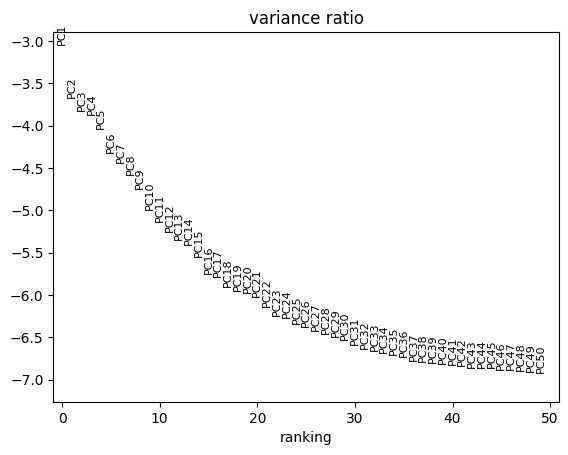

In [87]:
#Plot PCA variance ratio for the BBKNN data
sc.pl.pca_variance_ratio(adata.bbknn, n_pcs=50, log=True)

In [88]:
#Performing BKNN (Batch-KNN) integration using the sample as the batch key to remove batch effects
sce.pp.bbknn(adata.bbknn, batch_key='sample')

computing batch balanced neighbors
	finished (0:00:00)


In [89]:
#Calculate nearest neighbors again after BBKNN integration
sc.pp.neighbors(adata.bbknn, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:35)


running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:12)


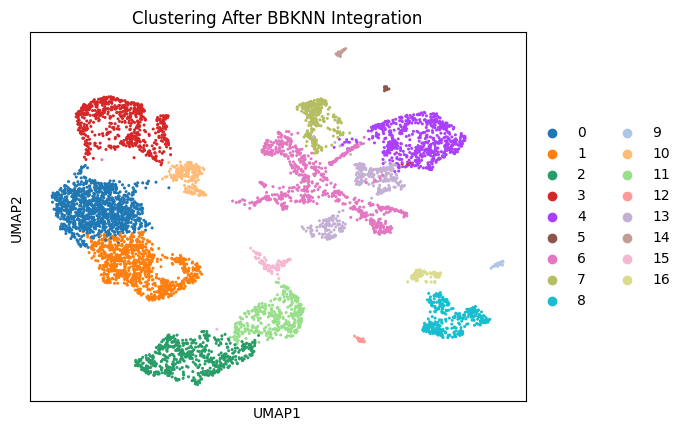

In [110]:
#Visualize clusters using UMAP after BBKNN integration using a resolution of 0.3 to give clusters between 10-20 (16 in this case) to get a good understanding of the cell types present in data
cluster_umap(adata.bbknn, title='Clustering After BBKNN Integration', resolution=0.3)

In [92]:
#Count the number of cells in each cluster
cluster_counts = adata.bbknn.obs['leiden'].value_counts()
print(cluster_counts)

leiden
0     1125
1      853
6      732
3      646
4      614
2      562
11     368
13     336
8      322
7      272
10     196
15      88
16      85
14      29
9       29
12      27
5       16
Name: count, dtype: int64


ranking genes
    finished (0:00:11)


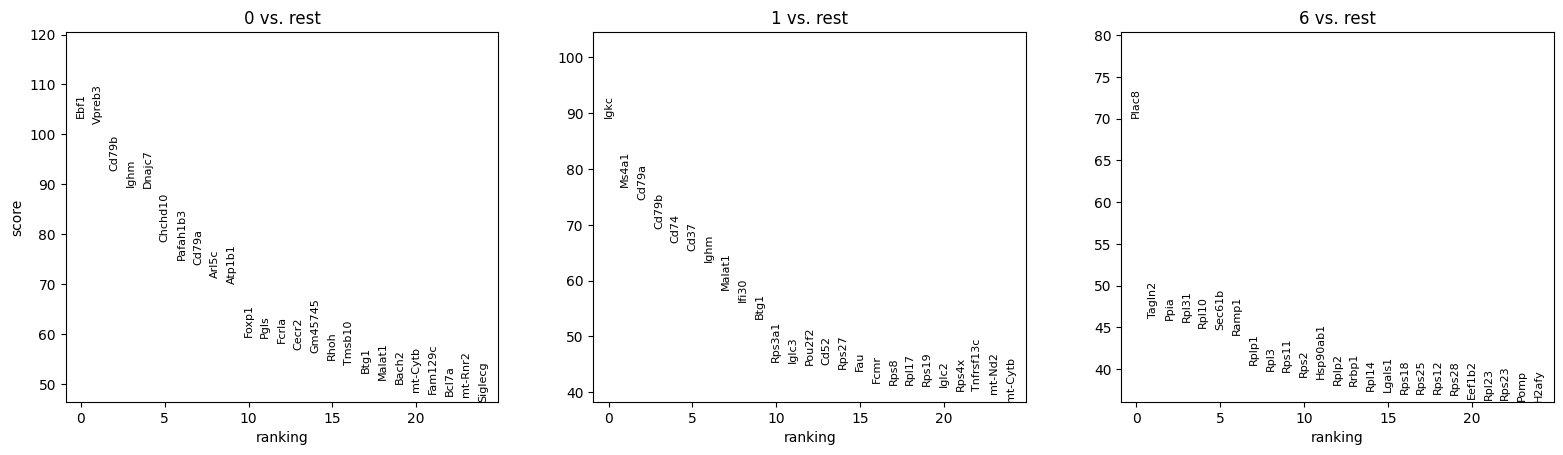

Top marker genes for Cluster 0:['Ebf1' 'Vpreb3' 'Cd79b' 'Ighm' 'Dnajc7' 'Chchd10' 'Pafah1b3' 'Cd79a'
 'Arl5c' 'Atp1b1' 'Foxp1' 'Pgls' 'Fcrla' 'Cecr2' 'Gm45745' 'Rhoh' 'Tmsb10'
 'Btg1' 'Malat1' 'Bach2' 'mt-Cytb' 'Fam129c' 'Bcl7a' 'mt-Rnr2' 'Siglecg']

Top marker genes for Cluster 1:['Igkc' 'Ms4a1' 'Cd79a' 'Cd79b' 'Cd74' 'Cd37' 'Ighm' 'Malat1' 'Ifi30'
 'Btg1' 'Rps3a1' 'Iglc3' 'Pou2f2' 'Cd52' 'Rps27' 'Fau' 'Fcmr' 'Rps8'
 'Rpl17' 'Rps19' 'Iglc2' 'Rps4x' 'Tnfrsf13c' 'mt-Nd2' 'mt-Cytb']

Top marker genes for Cluster 6:['Plac8' 'Tagln2' 'Ppia' 'Rpl31' 'Rpl10' 'Sec61b' 'Ramp1' 'Rplp1' 'Rpl3'
 'Rps11' 'Rps2' 'Hsp90ab1' 'Rplp2' 'Rrbp1' 'Rpl14' 'Lgals1' 'Rps18'
 'Rps25' 'Rps12' 'Rps28' 'Eef1b2' 'Rpl23' 'Rps23' 'Pomp' 'H2afy']



In [97]:
#Perform differential gene expression analysis between top 3 clusters using the t-test method
#This step identifies markers for each cluster
sc.tl.rank_genes_groups(adata.bbknn, groupby='leiden', method='t-test', min_in_group_fraction=0.25)

#Select the top 3 clusters (0, 1, 6 here based on cluster size)
top_3_clusters = ['0', '1', '6']

#Plot the top-ranked genes for only the top 3 clusters
sc.pl.rank_genes_groups(adata.bbknn, n_genes=25, groups=top_3_clusters, sharey=False)

#Print the top marker genes for each of the top 3 clusters
for cluster in top_3_clusters:
    #Get the top 25 genes for the current cluster
    top_genes = adata.bbknn.uns['rank_genes_groups']['names'][cluster][:25]
    print(f'Top marker genes for Cluster {cluster}:{top_genes}\n')

In [111]:
#Define new cluster names for clusters 0, 1, and 6 in BBKNN UMAP
new_cluster_names = ['Immature B cells',  'Mature B cells',  '2', '3', '4', '5', 'Myeloid Cells', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',]

#Rename the 3 largest clusters as per predicted cell type from marker genes
adata.bbknn.rename_categories('leiden', new_cluster_names)

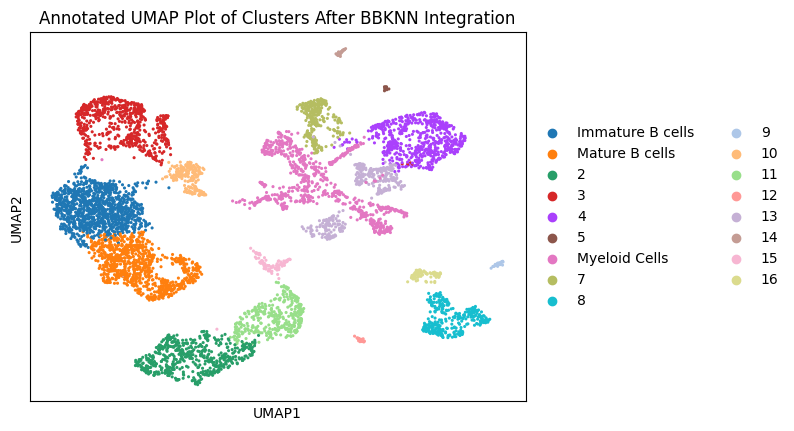

In [112]:
#Plot UMAP with renamed cluster categories
sc.pl.umap(adata.bbknn, color='leiden', legend_loc='right margin', 
           title='Annotated UMAP Plot of Clusters After BBKNN Integration', 
           size=20, legend_fontsize=10)

In [113]:
#Calculate the relative frequency of each cluster
cluster_counts = adata.bbknn.obs['leiden'].value_counts()
total_cells = len(adata.bbknn)
cell_frequencies = cluster_counts / total_cells  

#Calculate proportions per sample
cluster_sample_counts = pd.crosstab(adata.bbknn.obs['leiden'], adata.bbknn.obs['sample'], normalize='columns')

#Convert to DataFrame for easier plotting and manipulation
freq_table_sample = cluster_sample_counts.reset_index().melt(id_vars='leiden', var_name='Sample', value_name='Proportion')
freq_table_sample = freq_table_sample.rename(columns={'leiden': 'Cluster'})

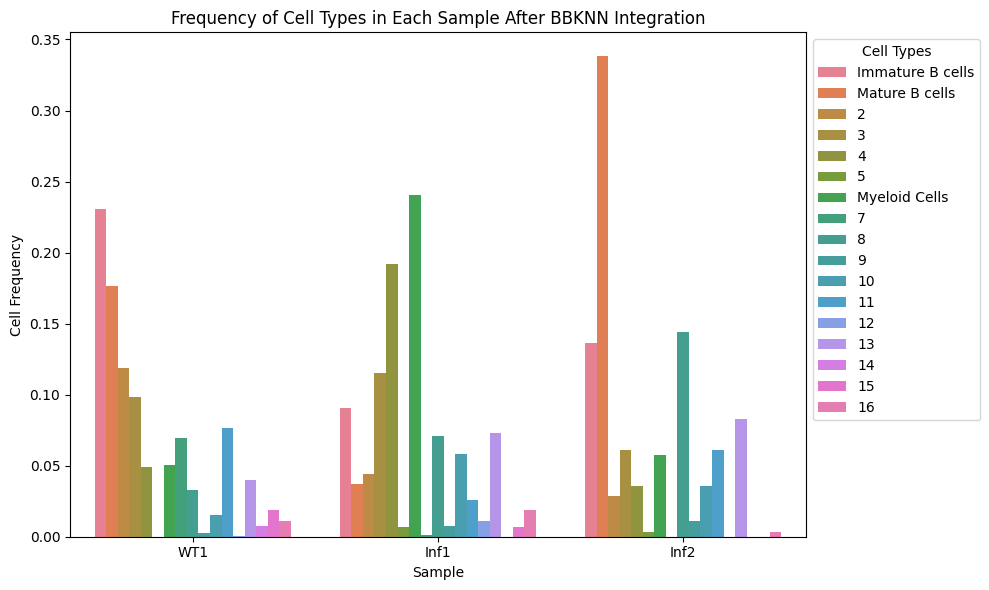

In [114]:
#Create a bar plot for cell type proportions across samples
plt.figure(figsize=(10, 6))
sns.barplot(data=freq_table_sample, x='Sample', y='Proportion', hue='Cluster')
plt.title('Frequency of Cell Types in Each Sample After BBKNN Integration')
plt.xlabel('Sample')
plt.ylabel('Cell Frequency')
plt.legend(title='Cell Types', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**Differential Expression Analysis and Pathway Enrichment**

A new condition column is added to BBKNN adata object based on the sample identifiers, distinguishing between 'Wild Type' and 'Infected' samples. The expression of the gene Ms4a1 (selected gene) is visualized across clusters using violin plots, dot plots, and UMAP.

The dataset is then subsetted to include only cells from the 'Mature B cells' cluster (the cluster containing Ms4a1). Differential expression analysis is performed on this subset using the created function to obtain upregulated genes, followed by gene ranking and pathway enrichment analysis to identify significantly enriched pathways in the Infected group. The results of the enrichment analysis are visualized with a bar plot for pathway enrichment.

In [115]:
#Add a condition column based on the sample for BBKNN
adata.bbknn.obs['condition'] = adata.bbknn.obs['sample'].map(lambda x: 'Wild Type' if 'WT1' in x else 'Infected')

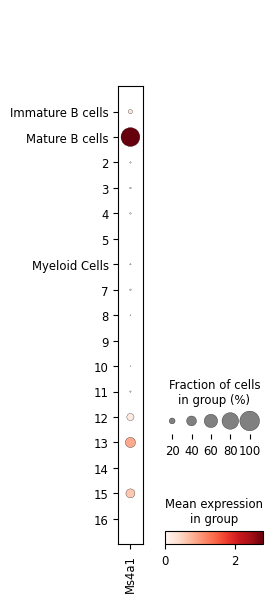

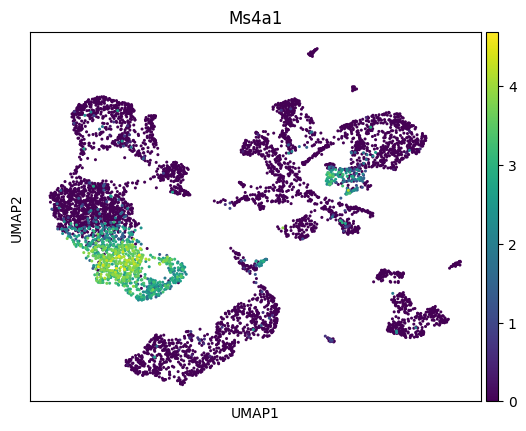

In [120]:
#Visualize the expression of Ms4a1 across all clusters for BBKNN to confirm its presence in Mature B cells cluster
sc.pl.dotplot(adata.bbknn, var_names=['Ms4a1'], groupby='leiden')
sc.pl.umap(adata.bbknn, color=['Ms4a1'])

In [117]:
#Subset the dataset to include only cells from cluster containing Ms4a1 i.e. B cells for BBKNN
bbknn_b_subset = adata.bbknn[adata.bbknn.obs['leiden'] == 'Mature B cells']
print(len(bbknn_b_subset.layers['counts']))

853


In [118]:
#Perform differential expression analysis on the subset for BBKNN
bbknn_upreg_genes = de_analysis(bbknn_b_subset)
print(len(bbknn_upreg_genes))

ranking genes


/home1/bioinfo-41/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished (0:00:00)
513


<Axes: title={'center': 'WikiPathways_2019_Mouse'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

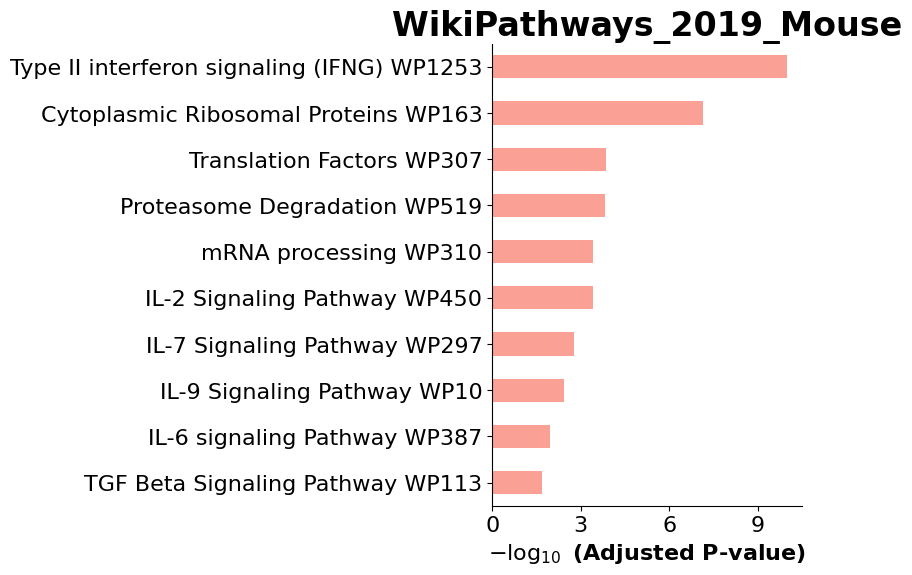

In [119]:
#Perform gene ranking and pathway enrichment analysis for BBKNN
gene_list = sc.get.rank_genes_groups_df(bbknn_b_subset, group='Infected', 
                                       log2fc_min=0.5, pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=gene_list, organism='Mouse', gene_sets='WikiPathways_2019_Mouse', cutoff=0.5)
gseapy.barplot(enr_res.res2d, title='WikiPathways_2019_Mouse')

**Harmony Integration and Clustering Analysis**

Harmony integration is also performed to remove batch effects. It is used to compare the results of BBKNN integration and Harmony integration and evaluate which method better handles batch effects and provides more meaningful clustering.

After performing PCA on the stored Harmony data, batch effects are integrated using the sample as the batch key for Harmony. Nearest neighbors are recalculated based on the integrated data, and UMAP visualization is applied to observe clustering patterns post-integration. The rank_genes_groups function is then used to identify marker genes for each cluster which are then plotted.

The number of cells in each cluster is counted to find the three largest clusters. A few of marker genes from those clusters are visualized in UMAP to examine their expression patterns. Finally, these clusters are renamed based on predicted cell types, and an annotated UMAP plot is generated to represent the clusters with their respective identities.

The relative frequency of each cluster is calculated by determining the number of cells in each cluster compared to the total number of cells. A bar plot is generated to visualize the cell type proportions for each sample.

In [121]:
#Perform PCA on the Harmony copy of data
sc.tl.pca(adata.hm, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:16)


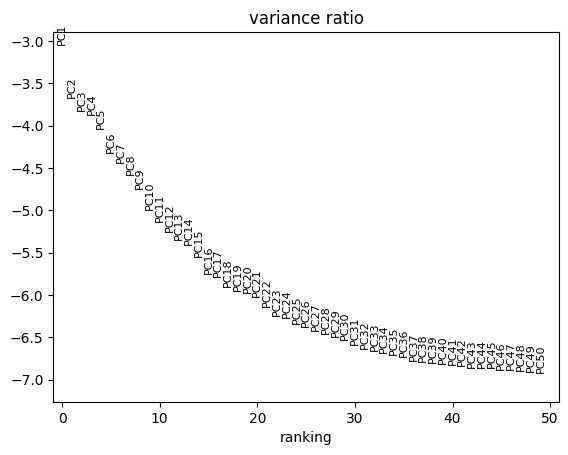

In [24]:
#Plot PCA variance ratio for the Harmony data
sc.pl.pca_variance_ratio(adata.hm, n_pcs=50, log=True)

In [122]:
#Perform Harmony integration using the sample as the batch key to remove batch effects
#Define extra parameters for Harmony integration via **kwargs to allow more iterations for convergence
extra_kwargs = {
    'max_iter_harmony': 20,  #Number of iterations for the Harmony algorithm
    'theta': 2.0,            #Regularization parameter
}
sce.pp.harmony_integrate(adata.hm, 'sample', **extra_kwargs)

2025-03-31 00:12:48,543 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-31 00:15:17,634 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-31 00:15:18,236 - harmonypy - INFO - Iteration 1 of 20
2025-03-31 00:15:28,629 - harmonypy - INFO - Iteration 2 of 20
2025-03-31 00:15:39,237 - harmonypy - INFO - Iteration 3 of 20
2025-03-31 00:15:51,636 - harmonypy - INFO - Iteration 4 of 20
2025-03-31 00:16:01,528 - harmonypy - INFO - Iteration 5 of 20
2025-03-31 00:16:08,033 - harmonypy - INFO - Iteration 6 of 20
2025-03-31 00:16:14,635 - harmonypy - INFO - Iteration 7 of 20
2025-03-31 00:16:19,036 - harmonypy - INFO - Iteration 8 of 20
2025-03-31 00:16:23,037 - harmonypy - INFO - Iteration 9 of 20
2025-03-31 00:16:28,429 - harmonypy - INFO - Iteration 10 of 20
2025-03-31 00:16:34,033 - harmonypy - INFO - Converged after 10 iterations


In [123]:
#Calculate nearest neighbors after integration
sc.pp.neighbors(adata.hm, use_rep='X_pca_harmony', n_neighbors=40)

computing neighbors
    finished (0:00:34)


running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:17)


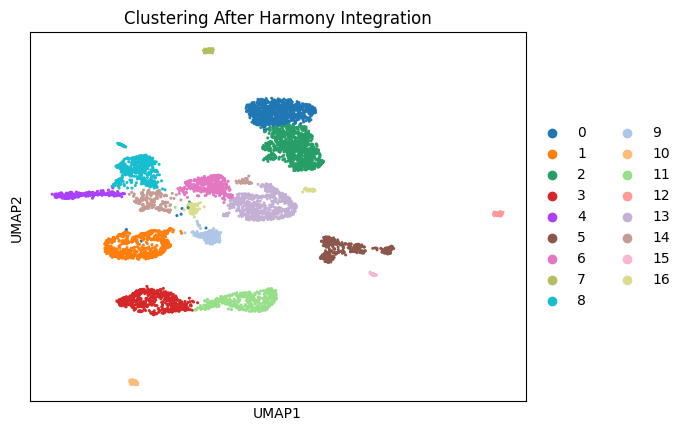

In [124]:
#Cluster visualization after Harmony integration using a resolution of 0.3 to give clusters between 10-20 (16 in this case) to get a good understanding of the cell types present in data
cluster_umap(adata.hm, title='Clustering After Harmony Integration', resolution=0.3)

In [125]:
#Count the number of cells in each cluster for Harmony integration
cluster_counts = adata.hm.obs['leiden'].value_counts()
print(cluster_counts)

leiden
2     886
0     876
13    638
1     636
8     516
3     499
11    424
5     405
6     388
14    241
4     229
9     206
16    118
12     70
10     70
7      69
15     29
Name: count, dtype: int64


ranking genes
    finished (0:00:12)


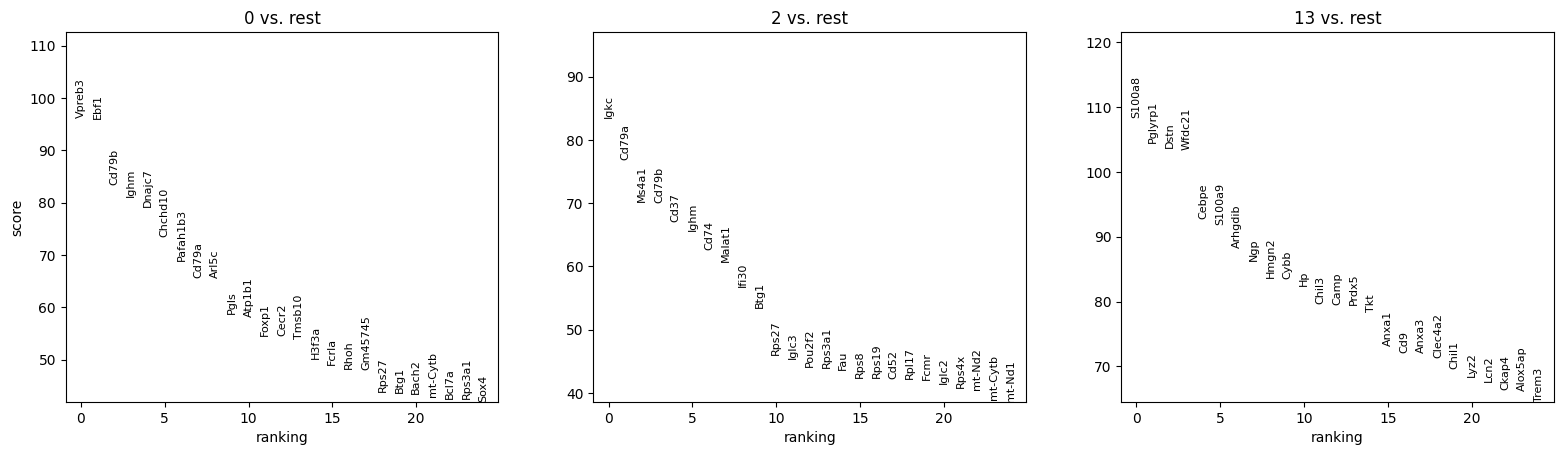

Top marker genes for Cluster 0:['Vpreb3' 'Ebf1' 'Cd79b' 'Ighm' 'Dnajc7' 'Chchd10' 'Pafah1b3' 'Cd79a'
 'Arl5c' 'Pgls' 'Atp1b1' 'Foxp1' 'Cecr2' 'Tmsb10' 'H3f3a' 'Fcrla' 'Rhoh'
 'Gm45745' 'Rps27' 'Btg1' 'Bach2' 'mt-Cytb' 'Bcl7a' 'Rps3a1' 'Sox4']

Top marker genes for Cluster 2:['Igkc' 'Cd79a' 'Ms4a1' 'Cd79b' 'Cd37' 'Ighm' 'Cd74' 'Malat1' 'Ifi30'
 'Btg1' 'Rps27' 'Iglc3' 'Pou2f2' 'Rps3a1' 'Fau' 'Rps8' 'Rps19' 'Cd52'
 'Rpl17' 'Fcmr' 'Iglc2' 'Rps4x' 'mt-Nd2' 'mt-Cytb' 'mt-Nd1']

Top marker genes for Cluster 13:['S100a8' 'Pglyrp1' 'Dstn' 'Wfdc21' 'Cebpe' 'S100a9' 'Arhgdib' 'Ngp'
 'Hmgn2' 'Cybb' 'Hp' 'Chil3' 'Camp' 'Prdx5' 'Tkt' 'Anxa1' 'Cd9' 'Anxa3'
 'Clec4a2' 'Chil1' 'Lyz2' 'Lcn2' 'Ckap4' 'Alox5ap' 'Trem3']



In [126]:
#Perform differential gene expression analysis between top 3 clusters using the t-test method
#This step identifies markers for each cluster
sc.tl.rank_genes_groups(adata.hm, groupby='leiden', method='t-test', min_in_group_fraction=0.25)

#Select the top 3 clusters (0, 1, 13 here based on cluster size)
top_3_clusters = ['0', '2', '13']

#Plot the top-ranked genes for only the top 3 clusters
sc.pl.rank_genes_groups(adata.hm, n_genes=25, groups=top_3_clusters, sharey=False)

#Print the top marker genes for each of the top 3 clusters
for cluster in top_3_clusters:
    #Get the top 25 genes for the current cluster
    top_genes = adata.hm.uns['rank_genes_groups']['names'][cluster][:25]
    print(f'Top marker genes for Cluster {cluster}:{top_genes}\n')

In [128]:
#Define predicted cell types for each cluster in Harmony
new_cluster_names = ['Immature B cells', '1', 'Mature B cells', '3', '4', '5', 'Myeloid Cells', '7', '8', '9', '10', '11', '12', 'Myeloid Cells', '14', '15', '16',]

#Rename the categories of 'leiden' in the adata object
adata.hm.rename_categories('leiden', new_cluster_names)

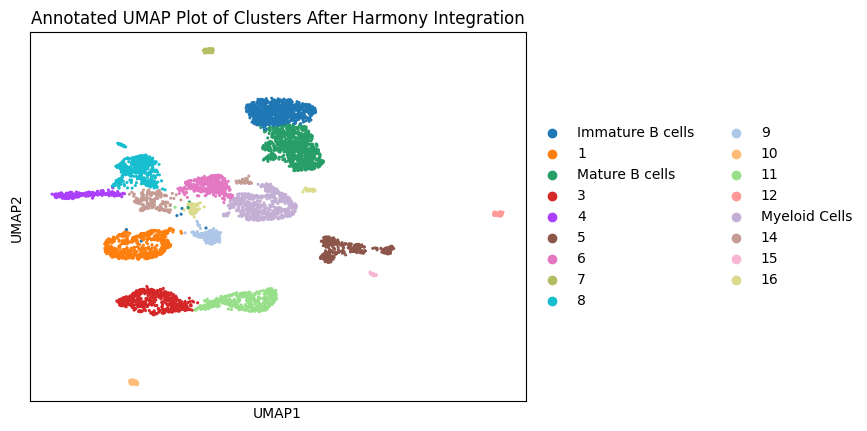

In [129]:
#Plot UMAP with renamed cluster categories
sc.pl.umap(adata.hm, color='leiden', legend_loc='right margin',  
           title='Annotated UMAP Plot of Clusters After Harmony Integration', 
           size=20, legend_fontsize=10)

In [130]:
#Calculate the relative frequency of each cluster for Harmony
cluster_counts = adata.hm.obs['leiden'].value_counts()
total_cells = len(adata.hm)
cell_frequencies = cluster_counts / total_cells

#Calculate proportions per sample for Harmony
cluster_sample_counts = pd.crosstab(adata.hm.obs['leiden'], adata.hm.obs['sample'], normalize='columns')
freq_table_sample = cluster_sample_counts.reset_index().melt(id_vars='leiden', var_name='Sample', value_name='Proportion')
freq_table_sample = freq_table_sample.rename(columns={'leiden': 'Cluster'})

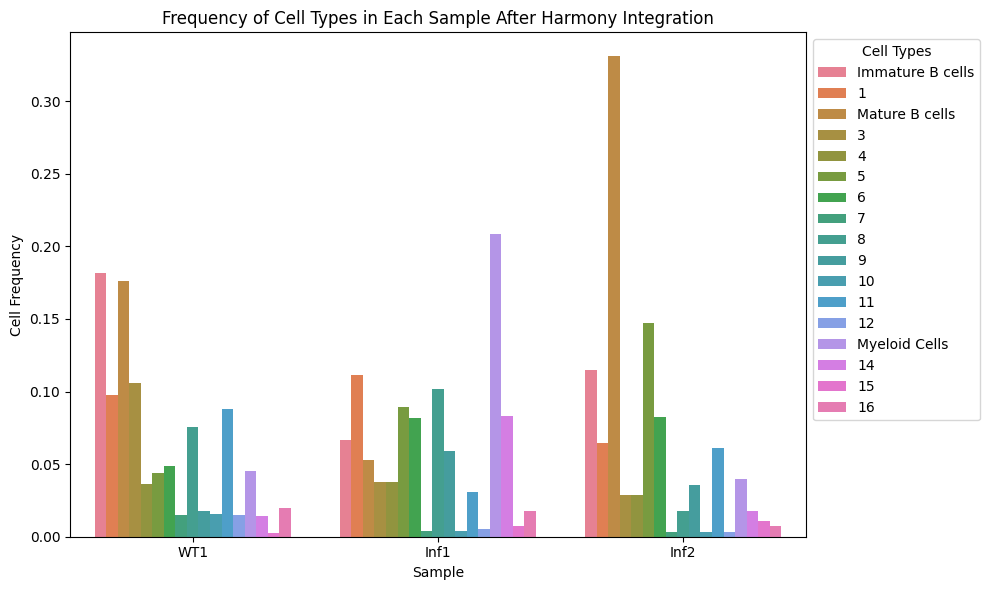

In [131]:
#Create a bar plot for cell type proportions across samples
plt.figure(figsize=(10, 6))
sns.barplot(data=freq_table_sample, x='Sample', y='Proportion', hue='Cluster')
plt.title('Frequency of Cell Types in Each Sample After Harmony Integration')
plt.xlabel('Sample')
plt.ylabel('Cell Frequency')
plt.legend(title='Cell Types', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**Differential Expression Analysis and Pathway Enrichment**

A new condition column is added to Harmony adata object based on the sample identifiers, distinguishing between 'Wild Type' and 'Infected' samples. The expression of the gene Ms4a1 (selected gene) is visualized across clusters using violin plots, dot plots, and UMAP.

The dataset is then subsetted to include only cells from the 'Mature B cells' cluster (the cluster containing Ms4a1). Differential expression analysis is performed on this subset using the created function to obtain upregulated genes, followed by gene ranking and pathway enrichment analysis to identify significantly enriched pathways in the Infected group. The results of the enrichment analysis are visualized with a bar plot for pathway enrichment.

In [132]:
#Add a condition column to the adata object for Harmony
adata.hm.obs['condition'] = adata.hm.obs['sample'].map(lambda x: 'Wild Type' if 'WT1' in x else 'Infected')

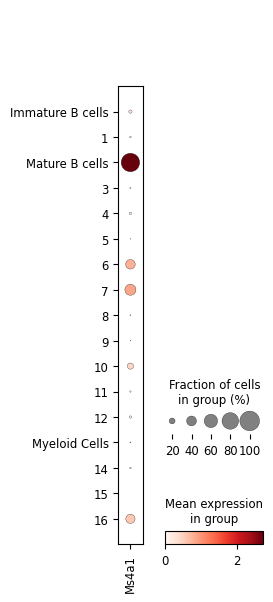

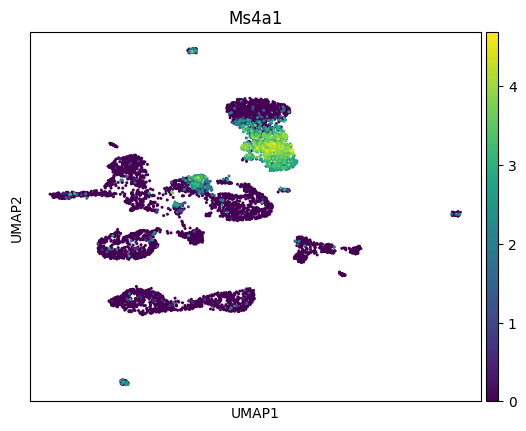

In [134]:
#Visualize the expression of Ms4a1 across all or clusters for Harmony
sc.pl.dotplot(adata.hm, var_names=['Ms4a1'], groupby='leiden')
sc.pl.umap(adata.hm, color=['Ms4a1'])

In [135]:
#Subset the dataset to include only cells from cluster containing Ms4a1 i.e. B cells cluster in Harmony
hm_b_subset = adata.hm[adata.hm.obs['leiden'] == 'Mature B cells']
print(len(hm_b_subset.layers['counts']))

886


In [136]:
#Perform differential expression analysis on the subset for Harmony
hm_upreg_genes = de_analysis(hm_b_subset)
print(len(hm_upreg_genes))

ranking genes


/home1/bioinfo-41/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished (0:00:00)
516


<Axes: title={'center': 'WikiPathways_2019_Mouse'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

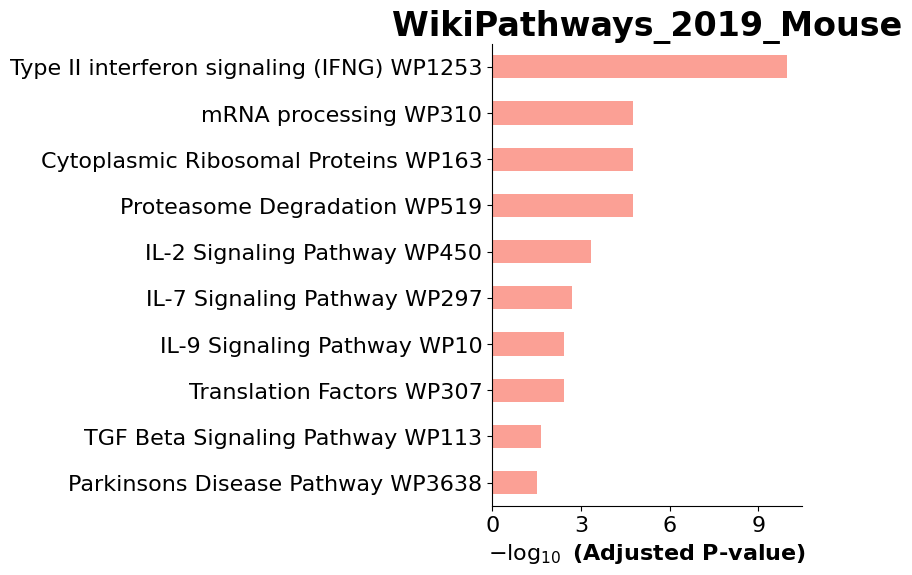

In [137]:
#Perform gene ranking and pathway enrichment analysis for Harmony
gene_list = sc.get.rank_genes_groups_df(hm_b_subset, group='Infected', 
                                       log2fc_min=0.5, pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=gene_list, organism='Mouse', gene_sets='WikiPathways_2019_Mouse', cutoff=0.5)
gseapy.barplot(enr_res.res2d, title='WikiPathways_2019_Mouse')

**Pseudobulk Differential Expression Analysis**

Pseudobulk data is created using the created pseudobulk function for the 'B cells' cluster from both the BBKNN and Harmony integrated datasets. Differential expression (DE) analysis is then performed on the pseudobulk data using the bulk_de_analysis function to obtain upregulated genes from both methods. The number of upregulated genes are noted for future comparison.

In [139]:
#Pseudobulk DE analysis
#Creating Pseudobulk data from BBKNN integrated data
pb_bbknn = pseudobulk(adata.bbknn, cluster_name='Mature B cells')

Cluster subset shape: (853, 2807)


In [140]:
#DE analysis of pseudobulk data to return upregulated genes
bbknn_bulk_upgenes = bulk_de_analysis(pb_bbknn)
print(len(bbknn_bulk_upgenes))

filtered out 163 genes that are detected in less than 1 cells
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.38 seconds.

Fitting dispersion trend curve...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 4.51 seconds.

Fitting LFCs...
... done in 3.32 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Infected vs Wild Type
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
4732440D04Rik  174.630588       -0.010127  0.335379 -0.030195  0.975911   
Pcmtd1         404.948152        0.304656  0.280491  1.086150  0.277413   
Gm38380         91.220701       -0.006541  0.645174 -0.010139  0.991911   
Ly96            34.493102       -0.633062  0.830111 -0.762623  0.445688   
Mcm3           165.649017        0.519802  0.594992  0.873629  0.382321   
...                   ...             ...       ...       ...       ...   
Prm1            14.229940        0.983531  2.496955  0.393892  0.693660   
Gm26822          3.895457        0.239755  4.008218  0.059816  0.952302   
Gm15657          4.415678        4.968235  4.619290  1.075541  0.282133   
Prss34           4.415678        4.968235  4.619290  1.075541  0.282133   
Gfra1           16.818029       -1.604593  2.299205 -0.697890  0.485246   

                   padj  
473

... done in 1.29 seconds.



In [141]:
#Creating Pseudobulk data from BBKNN integrated data
pb_hm = pseudobulk(adata.hm, cluster_name='Mature B cells')

Cluster subset shape: (886, 2807)


In [142]:
#DE analysis of pseudobulk data to return upregulated genes
hm_bulk_upgenes = bulk_de_analysis(pb_hm)
print(len(hm_bulk_upgenes))

filtered out 143 genes that are detected in less than 1 cells
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.40 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 4.51 seconds.

Fitting LFCs...
... done in 3.11 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Infected vs Wild Type
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
4732440D04Rik  183.965258       -0.031555  0.443917 -0.071083  0.943332   
Pcmtd1         472.140081        0.546064  0.373489  1.462063  0.143724   
Gm38380         96.148556       -0.056845  0.639572 -0.088880  0.929177   
Ly96            35.493995       -0.579946  0.813592 -0.712822  0.475956   
Mcm3           188.658297        0.737805  0.736010  1.002439  0.316131   
...                   ...             ...       ...       ...       ...   
Gm26822          9.538992        1.851923  3.158424  0.586344  0.557644   
Vpreb2          32.173747        7.830480  3.655521  2.142097  0.032186   
Gm15657          2.795866        4.304601  4.623577  0.931011  0.351848   
Prss34           2.681518        4.245630  4.624073  0.918158  0.358536   
Gfra1           33.625545       -0.100069  1.609346 -0.062180  0.950420   

                   padj  
473

... done in 1.23 seconds.



**Comparison of Upregulated Genes Across Methods**

Names of upregulated genes obtained after DE analysis on data obtained by the four different methods: BBKNN single-cell analysis, Harmony single-cell analysis, BBKNN pseudobulk analysis, and Harmony pseudobulk analysis are extracted and stored in a list. A bar plot is generated to compare the number of upregulated genes identified across these methods. The plot helps to visualize how the number of upregulated genes varies between these methods, providing a clear comparison of the results obtained through single-cell and pseudobulk approaches using different integration methods.

Additionally, a Venn diagram is created to illustrate the overlap of upregulated genes across the four methods. This diagram helps to identify which genes are shared between the different methods and which are unique to each.

In [143]:
#Obtain names of the upregulated genes from all 4 methods and store them in a list
bbknn_upreg_genes_list = bbknn_upreg_genes['Infected'].tolist()
hm_upreg_genes_list = hm_upreg_genes['Infected'].tolist()
bbknn_bulk_upgenes_list = bbknn_bulk_upgenes.index.tolist()
hm_bulk_upgenes_list = hm_bulk_upgenes.index.tolist()

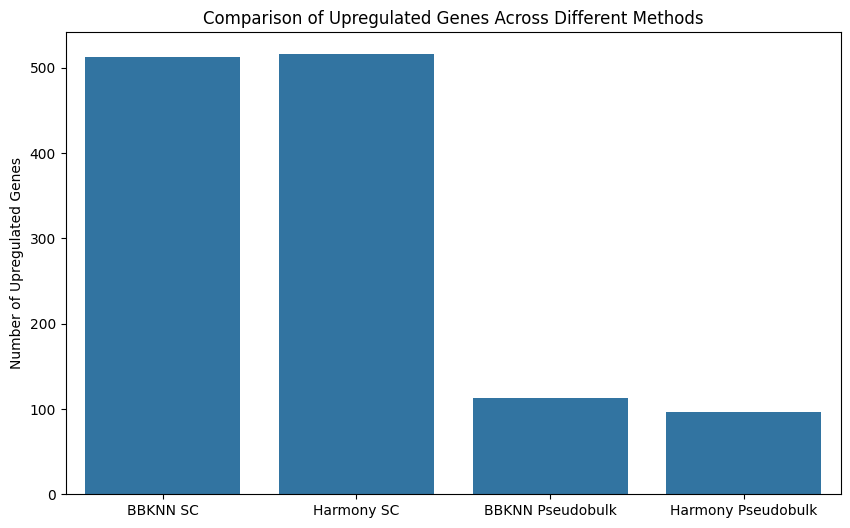

In [144]:
#Summary plot comparing upregulated genes across different methods
gene_lists = [bbknn_upreg_genes_list, hm_upreg_genes_list, 
              bbknn_bulk_upgenes_list, hm_bulk_upgenes_list]
methods = ['BBKNN SC', 'Harmony SC', 'BBKNN Pseudobulk', 'Harmony Pseudobulk']

plt.figure(figsize=(10, 6))
sns.barplot(x=['BBKNN SC', 'Harmony SC', 'BBKNN Pseudobulk', 'Harmony Pseudobulk'], 
            y=[len(bbknn_upreg_genes_list), len(hm_upreg_genes_list), 
               len(bbknn_bulk_upgenes_list), len(hm_bulk_upgenes_list)])
plt.title('Comparison of Upregulated Genes Across Different Methods')
plt.ylabel('Number of Upregulated Genes')
plt.show()

In [145]:
#Define the gene lists for each method
bbknn_sc = set(bbknn_upreg_genes_list)
hm_sc = set(hm_upreg_genes_list)
bbknn_pseudobulk = set(bbknn_bulk_upgenes_list)
hm_pseudobulk = set(hm_bulk_upgenes_list)

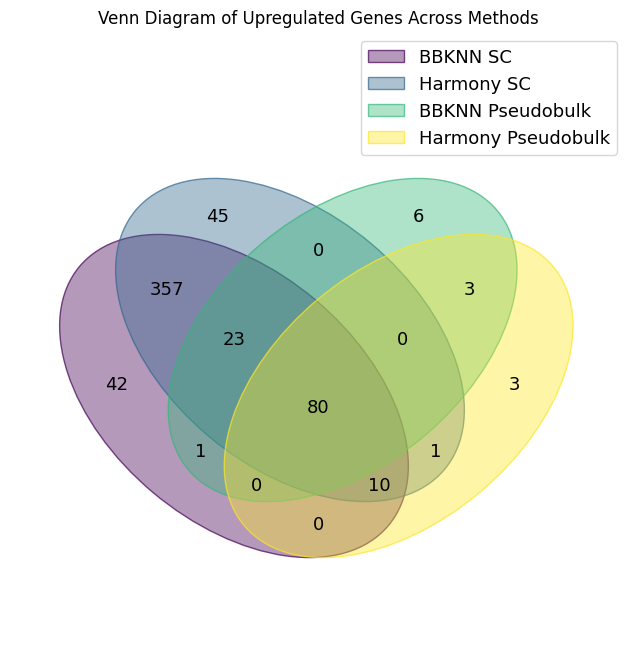

In [146]:
#Venn diagram to compare upregulated genes across methods
venn({
    'BBKNN SC': bbknn_sc,
    'Harmony SC': hm_sc,
    'BBKNN Pseudobulk': bbknn_pseudobulk,
    'Harmony Pseudobulk': hm_pseudobulk
})
plt.title('Venn Diagram of Upregulated Genes Across Methods')
plt.show()

**PAGA, UMAP and PHATE Analysis for BBKNN and Harmony Integrations**

PAGA (Partition-based Graph Abstraction) and PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) were used to perform trajectory analysis after integration using BBKNN and Harmony. The PAGA graphs were generated for both methods to visualize the relationship and trajectories between cell type clusters. Corresponding UMAP plots were also generated to display these clusters in two-dimensional space. PHATE analysis was conducted for both integrations to capture non-linear relationships between cells, with the resulting plots colored by Leiden cluster identities. To gain further insights into cluster relationships, the PAGA connectivities were printed for both BBKNN and Harmony. Finally, the PAGA results for both methods were compared using the paga_compare function, providing a visual comparison of cell type relationships.

running PAGA
    finished (0:00:00)


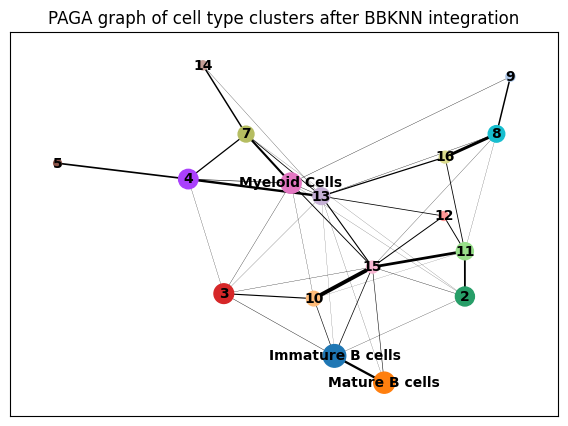

computing UMAP
    finished (0:00:07)


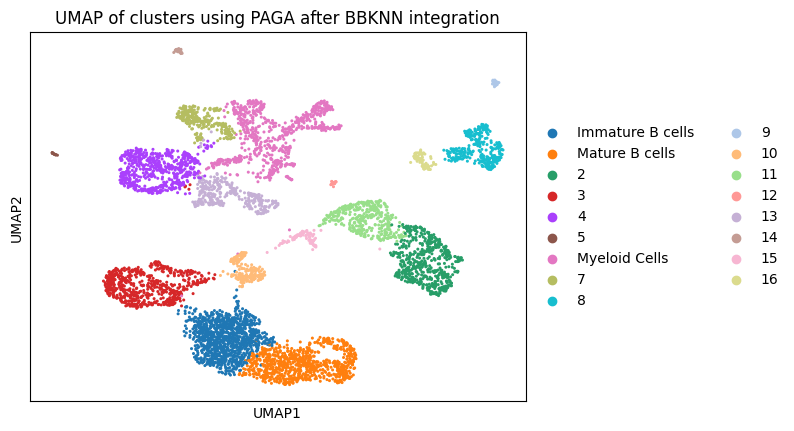

In [147]:
#PAGA and UMAP analysis for BBKNN using the same resolution as before
cluster_umap_paga(adata.bbknn, paga_title='PAGA graph of cell type clusters after BBKNN integration', umap_title='UMAP of clusters using PAGA after BBKNN integration', resolution=0.03)

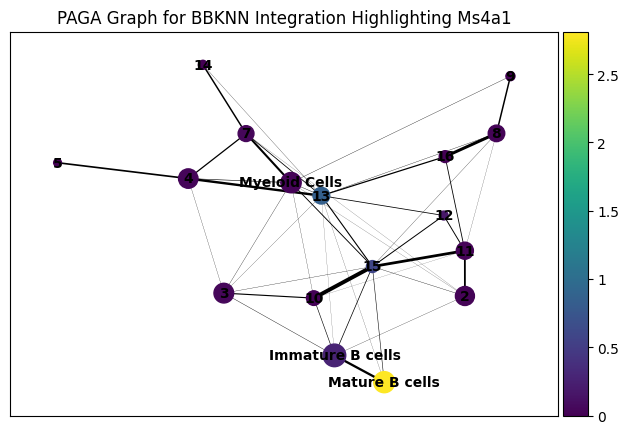

In [152]:
#PAGA graph visualization for BBKNN
sc.pl.paga(adata.bbknn, color=['Ms4a1'], layout='fr', title='PAGA Graph for BBKNN Integration Highlighting Ms4a1', show=True)

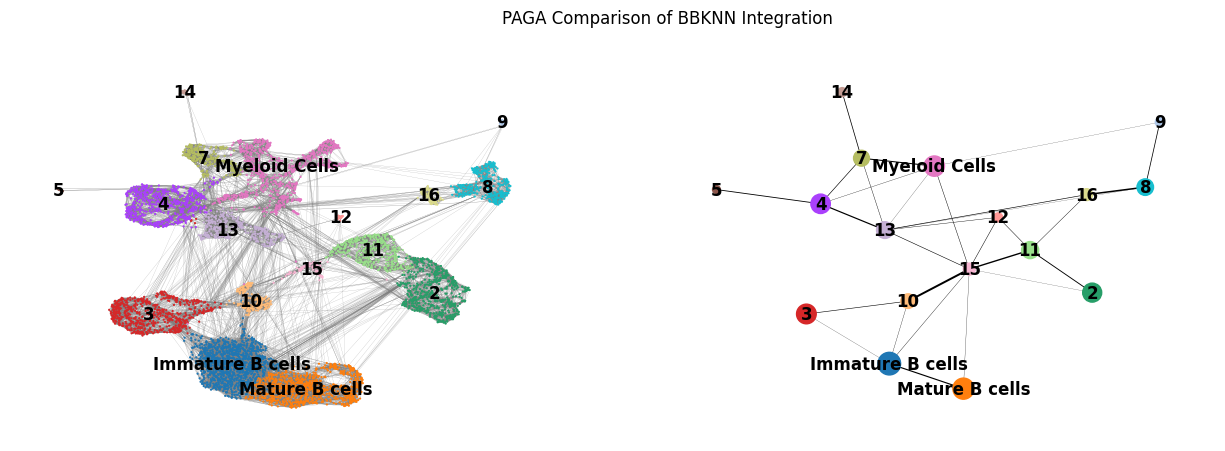

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [149]:
#Compare PAGA results for BBKNN Integration
sc.pl.paga_compare(
    adata.bbknn, threshold=0.03, title='PAGA Comparison of BBKNN Integration', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True
)

computing PHATE
Calculating PHATE...
  Running PHATE on 6300 observations and 2807 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 16.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.01 seconds.
    Calculating affinities...
    Calculated affinities in 1.04 seconds.
  Calculated graph and diffusion operator in 22.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 14.04 seconds.
    Calculating KMeans...
    Calculated KMeans in 220.20 seconds.
  Calculated landmark operator in 235.31 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 9.63 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.39 seconds.
Calculated PHATE in 274.66 seconds.
    finished (0:04:34)


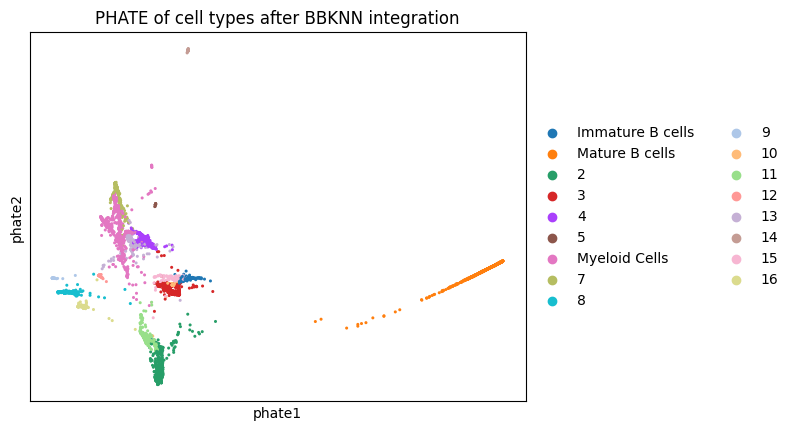

In [155]:
#PHATE analysis for BBKNN
sce.tl.phate(adata.bbknn, k=5, a=20, t=150)
sce.pl.phate(adata.bbknn, title='PHATE of cell types after BBKNN integration', color='leiden', color_map='tab20')

running PAGA
    finished (0:00:00)


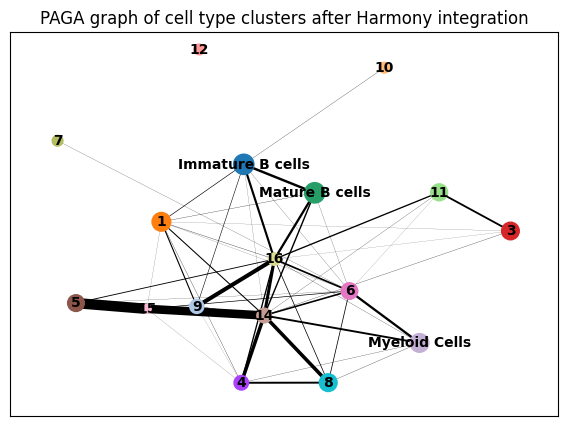

computing UMAP
    finished (0:00:11)


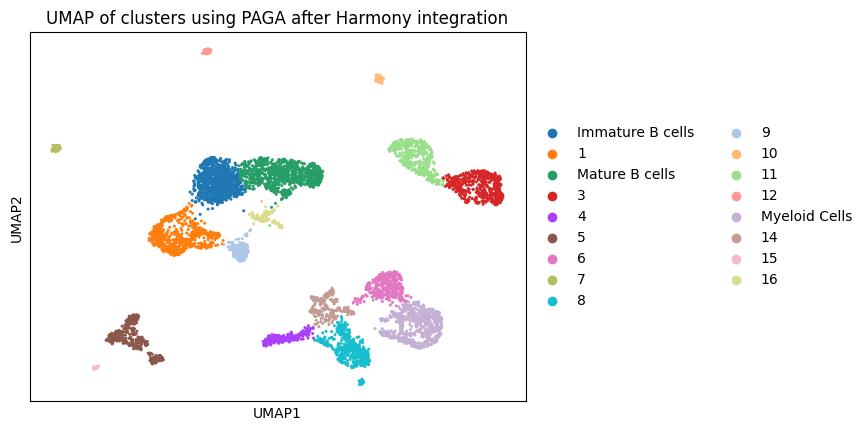

In [150]:
#PAGA and UMAP analysis for Harmony using the same resolution as before
cluster_umap_paga(adata.hm, paga_title='PAGA graph of cell type clusters after Harmony integration', umap_title='UMAP of clusters using PAGA after Harmony integration', resolution=0.03)

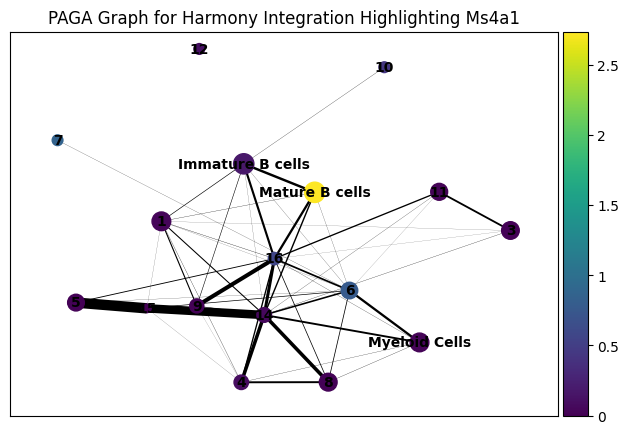

In [153]:
#PAGA graph visualization for Harmony
sc.pl.paga(adata.hm, color=['Ms4a1'], layout='fr', title='PAGA Graph for Harmony Integration Highlighting Ms4a1', show=True)

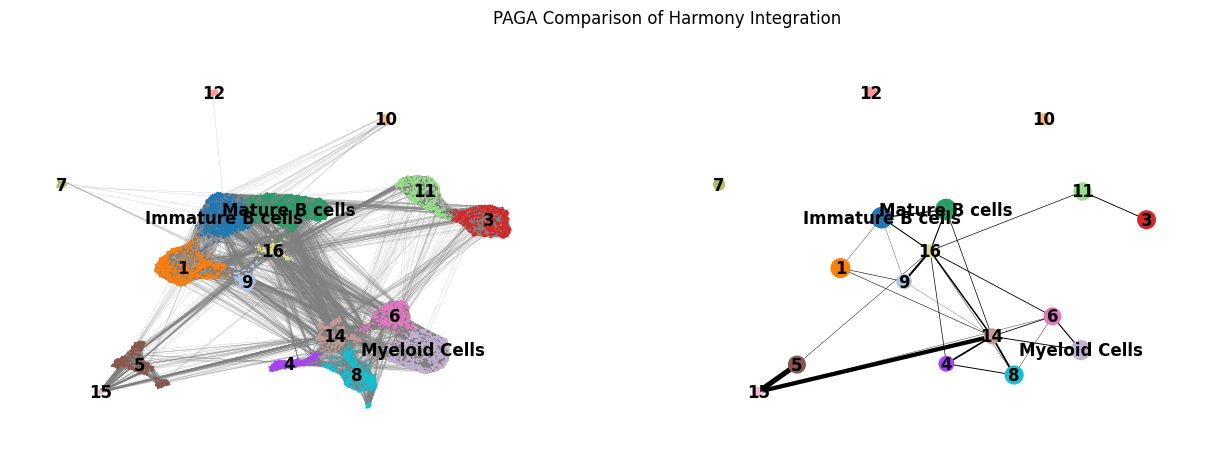

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [154]:
#Compare PAGA results for Harmony Integration
sc.pl.paga_compare(
    adata.hm, threshold=0.03, title='PAGA Comparison of Harmony Integration', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True
)

computing PHATE
Calculating PHATE...
  Running PHATE on 6300 observations and 2807 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 27.40 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.91 seconds.
    Calculating affinities...
    Calculated affinities in 1.01 seconds.
  Calculated graph and diffusion operator in 33.44 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 11.16 seconds.
    Calculating KMeans...
    Calculated KMeans in 304.79 seconds.
  Calculated landmark operator in 316.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 12.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.96 seconds.
Calculated PHATE in 368.48 seconds.
    finished (0:06:08)


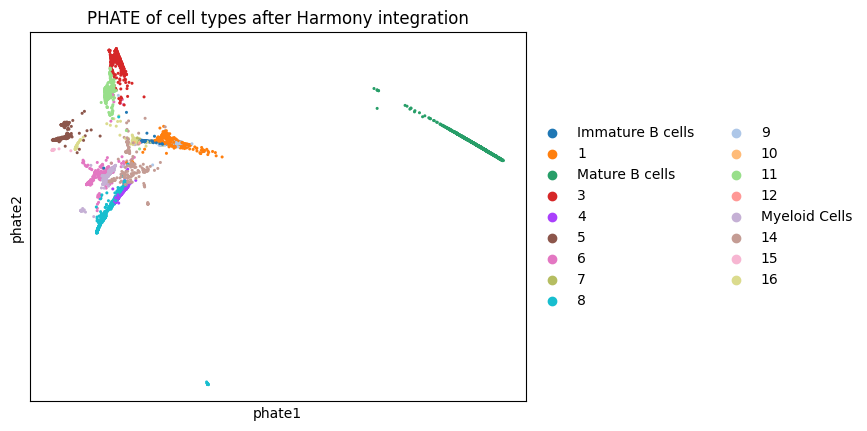

In [157]:
#PHATE analysis for Harmony
sce.tl.phate(adata.hm, k=5, a=20, t=150)
sce.pl.phate(adata.hm, color='leiden', title='PHATE of cell types after Harmony integration', color_map='tab20')